In [16]:
import pandas_ta as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the data
data = pd.read_csv('../../data/processed-data/g_2010_2023.csv', parse_dates=True, index_col='Date')

# Add several technical indicators
data['SMA_20'] = ta.sma(data['close'], length=20)  # 50-day Simple Moving Average
data['RSI'] = ta.rsi(data['close'], length=14)  # Relative Strength Index (14-day)
# data['MACD'] = ta.macd(data['close'])['MACD']  # MACD (Moving Average Convergence Divergence)
data['ATR'] = ta.atr(data['high'], data['low'], data['close'], length=14)  # Average True Range
data.ta.macd(append=True)

data.dropna(inplace=True)
data.head()

,close,open,high,low,volume,SMA_20,RSI,ATR,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,,
2010-02-22,1113.1,1122.1,1131.5,1110.0,137550.0,1094.805,53.590093,24.216037,-3.999113,9.175987,-13.175100
2010-02-23,1103.2,1114.1,1121.7,1099.6,161290.0,1095.180,49.690402,24.051662,-3.831580,7.474816,-11.306396
2010-02-24,1097.2,1103.5,1108.8,1090.2,176130.0,1095.125,47.437372,23.630803,-4.135290,5.736885,-9.872175
2010-02-25,1108.5,1096.2,1110.0,1088.5,206760.0,1096.325,51.864031,23.467253,-3.424688,5.157989,-8.582677
2010-02-26,1118.9,1108.0,1119.5,1104.6,129610.0,1098.030,55.572467,22.813155,-1.999292,5.266708,-7.266000


In [37]:
def add_target(df, lookahead=5):
    """
    Add a 'target' column to the DataFrame.
    Look ahead up to number(lookahead) days; as soon as:
      - Close ≥ current_close + 1.5*ATR  ⇒ target = 1
      - Close ≤ current_close − 1.5*ATR  ⇒ target = -1
    If neither threshold is hit within 7 days ⇒ target = 0
    """
    df = df.copy()
    closes = df['close'].values
    atrs   = df['ATR'].values
    n      = len(df)
    targets = np.zeros(n, dtype=int)

    for i in range(n):
        up_thresh   = closes[i] + 1.5* atrs[i]
        down_thresh = closes[i] - 1.5* atrs[i]
        # look ahead day by day
        for future_close in closes[i+1 : i+1+lookahead]:
            if future_close >= up_thresh:
                targets[i] = 1
                break
            elif future_close <= down_thresh:
                targets[i] = -1
                break
        # if loop exits normally, targets[i] stays 0

    df['target'] = targets
    return df
data = add_target(data)
data.dropna(inplace=True)
data.to_csv("../../data/processed-data/g_2010_2023_with_target_mult_1.csv", index=True)
data.head()

,close,open,high,low,volume,SMA_20,RSI,ATR,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,target
Date,,,,,,,,,,,,
2010-02-22,1113.1,1122.1,1131.5,1110.0,137550.0,1094.805,53.590093,24.216037,-3.999113,9.175987,-13.175100,0
2010-02-23,1103.2,1114.1,1121.7,1099.6,161290.0,1095.180,49.690402,24.051662,-3.831580,7.474816,-11.306396,0
2010-02-24,1097.2,1103.5,1108.8,1090.2,176130.0,1095.125,47.437372,23.630803,-4.135290,5.736885,-9.872175,1
2010-02-25,1108.5,1096.2,1110.0,1088.5,206760.0,1096.325,51.864031,23.467253,-3.424688,5.157989,-8.582677,0
2010-02-26,1118.9,1108.0,1119.5,1104.6,129610.0,1098.030,55.572467,22.813155,-1.999292,5.266708,-7.266000,0


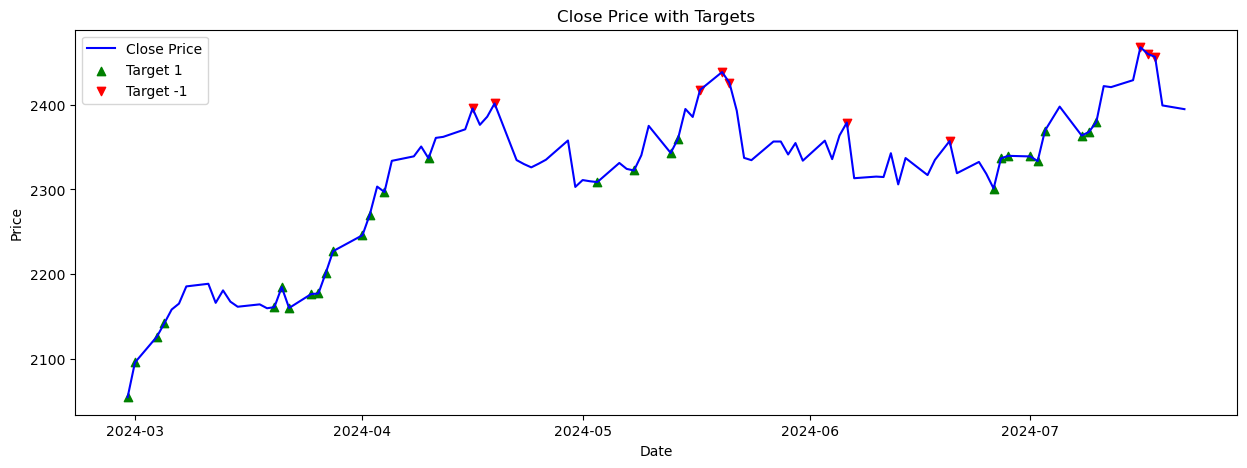

In [38]:
#PLOT THE TARGET for 300 -200days
plt.figure(figsize=(15, 5))
plt.plot(data.index[-300:-200], data['close'][-300:-200], label='Close Price', color='blue')
# plt.plot(data.index[-300:-200], data['SMA_20'][-300:-200], label='SMA 20', color='orange')
plt.scatter(data.index[-300:-200][data['target'][-300:-200] == 1], data['close'][-300:-200][data['target'][-300:-200] == 1], marker='^', color='green', label='Target 1')
plt.scatter(data.index[-300:-200][data['target'][-300:-200] == -1], data['close'][-300:-200][data['target'][-300:-200] == -1], marker='v', color='red', label='Target -1')
plt.title('Close Price with Targets')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

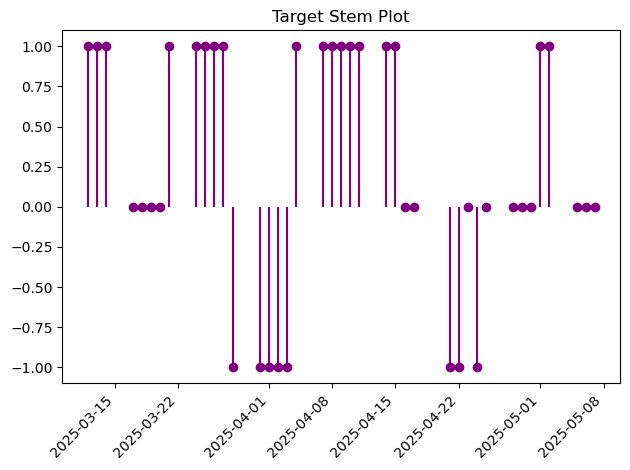

In [39]:
ser = data['target'].iloc[-40:]
plt.stem(ser.index, ser.values, linefmt='purple', markerfmt='o', basefmt=' ')
plt.xticks(rotation=45, ha='right')
plt.title('Target Stem Plot')
plt.tight_layout()
plt.show()

In [40]:
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

# # Feature columns (you can add more)
features = ['close', 'open', 'high', 'low', 'volume', 'SMA_20', 'RSI', 'ATR', 
            'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'target']


# target_col = 'target'

seq_len = 20

features = data.drop(columns=['target'])
target = data['target']

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)

# scaled_data['target'] = target.values

# Encode target as 0, 1, 2
target_map = {-1: 0, 0: 1, 1: 2}
y = target.map(target_map).values

# Create sequences
X, Y = [], []
for i in range(seq_len, len(data)):
    X.append(scaled_data[i-seq_len:i])
    Y.append(y[i])

X = np.array(X)
Y = to_categorical(Y, num_classes=3)
print(X.shape, Y.shape)


import joblib
joblib.dump(scaler, 'scaler.pkl')

(3855, 20, 11) (3855, 3)


['scaler.pkl']

In [43]:
from keras.models import Model
from keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D

def create_regularized_model(input_shape, num_classes=3):
    """
    Creates a regularized model to reduce overfitting.
    
    Args:
        input_shape (tuple): Shape of input data (timesteps, features).
        num_classes (int): Number of output classes.
        
    Returns:
        keras.Model: Compiled model.
    """
    inputs = Input(shape=input_shape)

    # Convolutional layer for feature extraction
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # LSTM layer for temporal dependencies
    x = LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)(x)

    # Fully connected layers with dropout
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Create and compile the model
regularized_model = create_regularized_model(input_shape=(seq_len, 11))
regularized_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
regularized_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 20, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 20, 32)         │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,827 (54.01 KB)

 Trainable params: 13,763 (53.76 KB)

 Non-trainable params: 64 (256.00 B)

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

regularized_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4371 - loss: 1.0706 - val_accuracy: 0.5966 - val_loss: 0.9544
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6364 - loss: 0.9215 - val_accuracy: 0.5966 - val_loss: 0.9687
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6318 - loss: 0.9181 - val_accuracy: 0.5966 - val_loss: 0.9768
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6213 - loss: 0.9272 - val_accuracy: 0.5966 - val_loss: 0.9891
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6246 - loss: 0.9269 - val_accuracy: 0.5966 - val_loss: 1.0004
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6253 - loss: 0.9100 - val_accuracy: 0.5966 - val_loss: 0.9777
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6336 - loss: 0.8976 - val_accuracy: 0.5966 - val_loss: 0.9908
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6377 - loss: 0.8948 - val_accuracy: 0.5966 - v

KeyboardInterrupt: 

In [ ]:
hist1 = model_regularized_with batch_size=3_weights.fit(
    X_train,
    Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, Y_test),
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)